#Integrantes de la tarea

Integrantes del grupo:

* Integrante 1:Matias Rodriguez U. Rut: 18362815-1
* Integrante 2:Paula Canales G. Rut:18845155-1
* Integrante 3:Sebastián Alday Rut:18294095-k
* Integrante 4:Álvaro Neira R. Rut:13757209-5

# Importación de Librerias

Estas son las bibliotecas y módulos necesarios.

In [ ]:
import pandas as pd
import re
import numpy as np
import spacy
import nltk
import sklearn
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# Datos Necesarios

Descargamos los datos necesarios para las actividades

In [ ]:
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/proveedoresA.txt
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/other_vhosts_access.log
nltk.download('stopwords')
nltk.download('wordnet')
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp_es = es_core_news_sm.load()

--2021-12-05 19:47:08--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29482924 (28M) [text/plain]
Saving to: ‘aysen.csv.2’

aysen.csv.2         100%[===================>]  28.12M   173MB/s    in 0.2s    

2021-12-05 19:47:08 (173 MB/s) - ‘aysen.csv.2’ saved [29482924/29482924]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 16.2 MB 11.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


# 1 Limpieza de la base de datos 


##Dataset

In [ ]:
aysen = pd.read_csv("aysen.csv", sep=";", na_values=["Otro",""])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 3. Análisis no supervisado

**En esta parte volví a calcular el D10K porque creo que así es más mejor**


In [ ]:
aysen_data = aysen[["SOSPECHA_DIAG","PRESTA_EST"]]

In [ ]:
import json
rank = json.loads(aysen_data.PRESTA_EST.value_counts().to_json())
rank = pd.DataFrame(list(rank.items()),columns = ['PRESTA_EST','PRESTA_EST_COUNT'])
rank = rank.loc[rank['PRESTA_EST_COUNT'] > 10000]
rank

,PRESTA_EST,PRESTA_EST_COUNT
0,TRAUMATOLOGIA,24004
1,OFTALMOLOGIA,21482
2,CIRUGIA ADULTO,17321
3,OTORRINOLARINGOLOGIA,13663
4,NEUROLOGIA,12316
5,MEDICINA INTERNA,11408
6,GINECOLOGIA,10871
7,ENDODONCIA,10225


In [ ]:
rank_list = rank.PRESTA_EST.values.tolist()
rank_list

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

In [ ]:
D10K = aysen_data.loc[aysen_data['PRESTA_EST'].isin(rank_list)]
D10K

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
4,Celulitis y absceso de boca,ENDODONCIA
6,FISURA ANAL,CIRUGIA ADULTO
7,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
8,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
217886,HIPERTENSION ESENCIAL (PRIMARIA),MEDICINA INTERNA
217888,Consulta no Especificada,MEDICINA INTERNA
217889,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
217892,Consulta no Especificada,CIRUGIA ADULTO


## 3.1 Probabilidad de cada categoría en D10K

In [ ]:
total = rank.PRESTA_EST_COUNT.sum()
rank['PROB'] = rank.PRESTA_EST_COUNT/total
rank

,PRESTA_EST,PRESTA_EST_COUNT,PROB
0,TRAUMATOLOGIA,24004,0.197906
1,OFTALMOLOGIA,21482,0.177113
2,CIRUGIA ADULTO,17321,0.142806
3,OTORRINOLARINGOLOGIA,13663,0.112647
4,NEUROLOGIA,12316,0.101542
5,MEDICINA INTERNA,11408,0.094056
6,GINECOLOGIA,10871,0.089628
7,ENDODONCIA,10225,0.084302


In [ ]:
total

121290

## 3.2 Diccionario P(palabra|categoria).

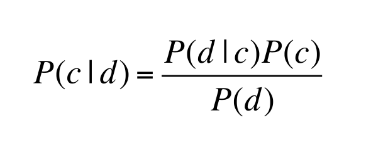

Se divide en entrenamiento y test la data de D10K (90% y 10% respectivamente)

In [ ]:
train, test = train_test_split(D10K, test_size=0.1)

Se construye el vector en base a la data de entrenamiento

In [ ]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer() #Se podrían quitar las stopwords
term_doc_matrix_train = count_vectorizer.fit_transform(train.SOSPECHA_DIAG)
#term_doc_matrix_train = count_vectorizer.fit_transform(D10KOTRO.SOSPECHA_DIAG)
term_doc_matrix_train

<109161x4383 sparse matrix of type '<class 'numpy.int64'>'
	with 444234 stored elements in Compressed Sparse Row format>

Se calcula la probabilidad de cada palabra según categoría

#Ejemplo Matías

##Dataset Ejemplo

In [ ]:
D10K=D10K.reset_index(drop=True)

In [ ]:
D10KOTRO=D10K.loc[[0,1,2,3,4,5],["SOSPECHA_DIAG","PRESTA_EST"]]

In [ ]:
D10KOTRO["SOSPECHA_DIAG"].iloc[0]="Celulitis boca"
D10KOTRO["SOSPECHA_DIAG"].iloc[1]="Celulitis boca"
D10KOTRO["SOSPECHA_DIAG"].iloc[2]="Fisura"
D10KOTRO["SOSPECHA_DIAG"].iloc[3]="Periodontitis"
D10KOTRO["SOSPECHA_DIAG"].iloc[4]="Osteomielitis"
D10KOTRO["SOSPECHA_DIAG"].iloc[5]="No Especificado"

In [ ]:
D10KOTRO

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis boca,ENDODONCIA
1,Celulitis boca,ENDODONCIA
2,Fisura,CIRUGIA ADULTO
3,Periodontitis,ENDODONCIA
4,Osteomielitis,TRAUMATOLOGIA
5,No Especificado,GINECOLOGIA


In [ ]:
list(D10KOTRO["PRESTA_EST"].unique())

['ENDODONCIA', 'CIRUGIA ADULTO', 'TRAUMATOLOGIA', 'GINECOLOGIA']

##Cálculo Paula en ejemplo

In [ ]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer() #Se podrían quitar las stopwords
#term_doc_matrix_train = count_vectorizer.fit_transform(train.SOSPECHA_DIAG)
term_doc_matrix_train = count_vectorizer.fit_transform(D10KOTRO.SOSPECHA_DIAG)
term_doc_matrix_train

<6x7 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == "ENDODONCIA",:].sum(0)).reshape(-1)

array([2, 2, 0, 0, 0, 0, 1])

In [ ]:
count_vectorizer.get_feature_names_out()

array(['boca', 'celulitis', 'especificado', 'fisura', 'no',
       'osteomielitis', 'periodontitis'], dtype=object)

In [ ]:
np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == "ENDODONCIA",:].sum(0)).reshape(-1).sum()

5

In [ ]:
count_c = (D10KOTRO.PRESTA_EST == "ENDODONCIA").sum()
count_c 

3

In [ ]:
import numpy as np

p_word_category = {}
#for category in rank_list:
for category in list(D10KOTRO["PRESTA_EST"].unique()):#El for lo cambie porque son menos clases  
  #count_c = (train.PRESTA_EST == category).sum()
  count_c = (D10KOTRO.PRESTA_EST == category).sum()#bueno cambie el train por el ejemplo
  # Se obtienen las apariciones de cada una de las palabras en cada clase
  #c_w = np.asarray(term_doc_matrix_train.todense()[train.PRESTA_EST == category,:].sum(0)).reshape(-1)
  c_w = np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1)#nuevamente camnbie el train por el ejemplo
  # Se calcula la probabilidad
  print(count_c)
  p_w = (c_w+1) / count_c
  p_word_category[category] = p_w
p_word_category

3
1
1
1


{'CIRUGIA ADULTO': array([1., 1., 1., 2., 1., 1., 1.]),
 'ENDODONCIA': array([1.        , 1.        , 0.33333333, 0.33333333, 0.33333333,
        0.33333333, 0.66666667]),
 'GINECOLOGIA': array([1., 1., 2., 1., 2., 1., 1.]),
 'TRAUMATOLOGIA': array([1., 1., 1., 1., 1., 2., 1.])}

##Cálculo Mati en ejemplo (la probabilidad normal)

In [ ]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer() #Se podrían quitar las stopwords
#term_doc_matrix_train = count_vectorizer.fit_transform(train.SOSPECHA_DIAG)
term_doc_matrix_train = count_vectorizer.fit_transform(D10KOTRO.SOSPECHA_DIAG)
term_doc_matrix_train

<6x7 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == "ENDODONCIA",:].sum(0)).reshape(-1)

array([2, 2, 0, 0, 0, 0, 1])

In [ ]:
np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == "ENDODONCIA",:].sum(0)).reshape(-1).sum()

5

In [ ]:
count_vectorizer.get_feature_names_out()

array(['boca', 'celulitis', 'especificado', 'fisura', 'no',
       'osteomielitis', 'periodontitis'], dtype=object)

In [ ]:
import numpy as np

p_word_category = {}
#for category in rank_list:
for category in list(D10KOTRO["PRESTA_EST"].unique()):#El for lo cambie porque son menos clases  
  #count_c = (train.PRESTA_EST == category).sum()
  count_c = np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1).sum()
  # Se obtienen las apariciones de cada una de las palabras en cada clase
  #c_w = np.asarray(term_doc_matrix_train.todense()[train.PRESTA_EST == category,:].sum(0)).reshape(-1)
  c_w = np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1)
  # Se calcula la probabilidad
  print(count_c)
  p_w = (c_w) / count_c
  p_word_category[category] = dict(zip(count_vectorizer.get_feature_names_out(), p_w))
p_word_category

5
1
1
2


{'CIRUGIA ADULTO': {'boca': 0.0,
  'celulitis': 0.0,
  'especificado': 0.0,
  'fisura': 1.0,
  'no': 0.0,
  'osteomielitis': 0.0,
  'periodontitis': 0.0},
 'ENDODONCIA': {'boca': 0.4,
  'celulitis': 0.4,
  'especificado': 0.0,
  'fisura': 0.0,
  'no': 0.0,
  'osteomielitis': 0.0,
  'periodontitis': 0.2},
 'GINECOLOGIA': {'boca': 0.0,
  'celulitis': 0.0,
  'especificado': 0.5,
  'fisura': 0.0,
  'no': 0.5,
  'osteomielitis': 0.0,
  'periodontitis': 0.0},
 'TRAUMATOLOGIA': {'boca': 0.0,
  'celulitis': 0.0,
  'especificado': 0.0,
  'fisura': 0.0,
  'no': 0.0,
  'osteomielitis': 1.0,
  'periodontitis': 0.0}}

A parte del cálculo que te comente ayer, agregue las palabras junto con sus clases. No se si es mejor al revés.

In [ ]:
p_word_category['ENDODONCIA']["boca"]

0.4

##Cálculo Mati en ejemplo (la probabilidad suavizada)

In [ ]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer() #Se podrían quitar las stopwords
#term_doc_matrix_train = count_vectorizer.fit_transform(train.SOSPECHA_DIAG)
term_doc_matrix_train = count_vectorizer.fit_transform(D10KOTRO.SOSPECHA_DIAG)
term_doc_matrix_train

<6x7 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == "ENDODONCIA",:].sum(0)).reshape(-1)

array([2, 2, 0, 0, 0, 0, 1])

In [ ]:
print("La sumatoria de palabras de la clase endocencia es ",np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == "ENDODONCIA",:].sum(0)).reshape(-1).sum())

La sumatoria de palabras de la clase endocencia es  5


In [ ]:
count_vectorizer.get_feature_names_out()

array(['boca', 'celulitis', 'especificado', 'fisura', 'no',
       'osteomielitis', 'periodontitis'], dtype=object)

In [ ]:
print("V es",len(np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1)))

V es 7


In [ ]:
import numpy as np

p_word_category = {}
#for category in rank_list:
for category in list(D10KOTRO["PRESTA_EST"].unique()):#El for lo cambie porque son menos clases  
  #count_c = (train.PRESTA_EST == category).sum()
  count_c = np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1).sum()
  V=len(np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1))
  # Se obtienen las apariciones de cada una de las palabras en cada clase
  #c_w = np.asarray(term_doc_matrix_train.todense()[train.PRESTA_EST == category,:].sum(0)).reshape(-1)
  c_w = np.asarray(term_doc_matrix_train.todense()[D10KOTRO.PRESTA_EST == category,:].sum(0)).reshape(-1)
  # Se calcula la probabilidad
  print(count_c)
  p_w = (c_w+1) / (count_c+V)
  p_word_category[category] = dict(zip(count_vectorizer.get_feature_names_out(), p_w))
p_word_category

5
1
1
2


{'CIRUGIA ADULTO': {'boca': 0.125,
  'celulitis': 0.125,
  'especificado': 0.125,
  'fisura': 0.25,
  'no': 0.125,
  'osteomielitis': 0.125,
  'periodontitis': 0.125},
 'ENDODONCIA': {'boca': 0.25,
  'celulitis': 0.25,
  'especificado': 0.08333333333333333,
  'fisura': 0.08333333333333333,
  'no': 0.08333333333333333,
  'osteomielitis': 0.08333333333333333,
  'periodontitis': 0.16666666666666666},
 'GINECOLOGIA': {'boca': 0.1111111111111111,
  'celulitis': 0.1111111111111111,
  'especificado': 0.2222222222222222,
  'fisura': 0.1111111111111111,
  'no': 0.2222222222222222,
  'osteomielitis': 0.1111111111111111,
  'periodontitis': 0.1111111111111111},
 'TRAUMATOLOGIA': {'boca': 0.125,
  'celulitis': 0.125,
  'especificado': 0.125,
  'fisura': 0.125,
  'no': 0.125,
  'osteomielitis': 0.25,
  'periodontitis': 0.125}}

A parte del cálculo que te comente ayer, agregue las palabras junto con sus clases. No se si es mejor al revés.

In [ ]:
p_word_category['ENDODONCIA']["boca"]

0.25